In [1]:
import Random#, logging
using  Plots, CSV, Gen#, Dates
using DataFrames: DataFrame
# Disable logging, because @animate is verbose otherwise
#Logging.disable_logging(Logging.Info);
include("../Step1-Data/DataGen.jl")
include("../Step1.5-Graphing_Model/GraphMaking.jl")


(process:21672): GLib-GIO-WARNING **: 13:39:05.798: Unexpectedly, UWP app `HaukeGtze.7-ZipFileManagerUnofficial_1.1900.3.0_x64__6bk20wvc8rfx2' (AUMId `HaukeGtze.7-ZipFileManagerUnofficial_6bk20wvc8rfx2!zFM.exe') supports 36 extensions but has no verbs

(process:21672): GLib-GIO-WARNING **: 13:39:05.840: Unexpectedly, UWP app `HaukeGtze.PuTTYSSHClient_1.76.2.0_x64__6bk20wvc8rfx2' (AUMId `HaukeGtze.PuTTYSSHClient_6bk20wvc8rfx2!pageant.exe') supports 1 extensions but has no verbs


visualize_trace (generic function with 1 method)

In [18]:
function DiffrenceIndex(i::Int)
    return(div(i,SubChunkSize,RoundUp))
end

DiffrenceIndex (generic function with 1 method)

given a, b. c defines d
2ax + b - 2cx = d 
slope,aski

In [44]:
function DiffrenceIndex(i::Int)
    return(div(i,SubChunkSize,RoundUp))
end
#Slopes,x,Buffer_y
SubChunkSize = 35
OutlierDeg = 2.5
#::Vector{Float64}, ::Float64, ::Vector{Float64}
function yValCalc(xs::Vector{Float64}, Buffer_y::Float64, Slopes::Vector{Float64})
    n = length(xs)
    NumChunks = DiffrenceIndex(n)


    #calculating the 'y intercept' of each chunk to make sure each line connects to the last one
    #Because each intercept gets added to the last one we take the cumalitive sum to get the total ofset needed at each step
    #The first value should be the initial ofset Buffer_y to get everything aligned
    #ysOfseted = [Buffer_y, Slope[chunk](x[chunk]- x[Last chunk])]
    ysOfseted = cumsum(pushfirst!([Slopes[i]*(xs[(i)*SubChunkSize] - xs[(i-1)*SubChunkSize+1]) for i=1:(NumChunks-1)],Buffer_y))
    
    
    #calculates the change of y from the previous chunk to the current x. We combine this with a set of y ofset values
    #in the next step to get the true mu fed into the normal distribution
    #TrueDeltaMu n = Slope[chunk](x[i]- x[Last chunk])
    TrueDeltaMu = [Slopes[DiffrenceIndex(i)]*(xs[i] - xs[div(i-1,SubChunkSize,RoundDown)*SubChunkSize+1]) for i=1:n]
    ys = [TrueDeltaMu[i] + ysOfseted[DiffrenceIndex(i)] for i=1:n]
end

@gen function regression_with_outliers(xs::Vector{<:Real})
    #First we calculate some useful values needed for the list comprehension in the next steps
    n = length(xs)
    NumChunks = DiffrenceIndex(n)

    # Next, we generate some parameters of the model. There are three types of randomly made perameters. First are the constant ones
    #That are unique to the process. These are generated first.
    #Second are the ones that are unique to the individual chunks. These loop from 1 to NumChunks
    #Last are the ones that vary for every point. These range from 1 to n


    #Unique to process

    #Where the series starts. In the log model this is around 12 and I give it a pretty big window
    Buffer_y ~ normal(10, 1) 
    
    #the probability any given point is a outlier
    prob_outlier ~ uniform(.01, .05)
    
    #unique to chunk

    #The data apears to have no slope over 3 so a sd of 2 should capture the true slopes with high probability
    Slopes = [{(:slope, i)} ~ normal(0, .05) for i=1:NumChunks]

    #The distribution of the noise. It gets fed into the sd of a normal distribution so the distribution of the noise needs to be always positive
    noise = [{(:noise, i)} ~ gamma(2, .15) for i=1:NumChunks]
   

    #EveryPoint

    #is using the prob_outlier vector above to decide if each point is an outlier. the model we are using now has 
    #The slope and sd $OutlierDeg times larger then the non outliers. so we times the mu and sd by this value in the last step
    PointOutlier = ((OutlierDeg-1)*[{:data => i => :is_outlier} ~ bernoulli(prob_outlier) for i=1:n] .+ 1)

    
    
    #The random var fit to the actual data. It is created as a combination of previous parts
    #The process was discribed in previous steps
    #ys = normal(mu, sd)
    TrueVec = yValCalc(xs,Buffer_y,Slopes)
    ys = [{:data => i => :y} ~ normal(TrueVec[i], noise[DiffrenceIndex(i)]*PointOutlier[i]) for i=1:n]
    ys
end;

In [45]:

function serialize_trace(trace)
    (xs,) = Gen.get_args(trace)
    n = length(xs)
    NumChunks = div(n, SubChunkSize, RoundUp)
    slopes = [trace[(:slope, i)] for i in 1:NumChunks]
    FlatDict = Dict(:Buffer_y => trace[:Buffer_y],
          :slope => slopes,
         :inlier_std => [trace[(:noise, i)] for i in 1:NumChunks],
         :points => zip(xs, [trace[:data => i => :y] for i in 1:length(xs)]),
         :xs => xs,
         :ys => yValCalc(xs, trace[:Buffer_y], slopes),
         :outliers => [trace[:data => i => :is_outlier] for i in 1:length(xs)])
    return(FlatDict)
end

serialize_trace (generic function with 1 method)

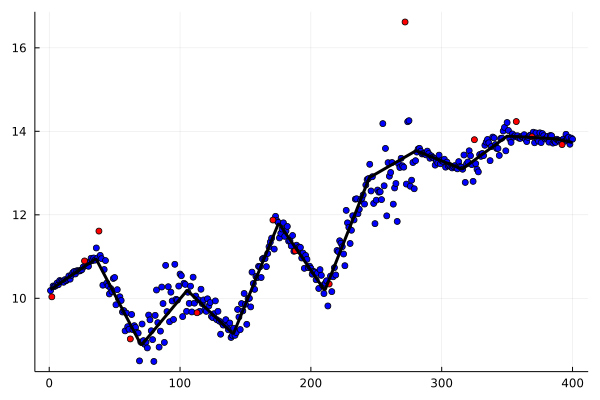

In [46]:
ts     = collect(range(1, stop=400, length=400))
traces = [Gen.simulate(regression_with_outliers, (ts,)) for i in 1:1]
Plots.plot([visualize_trace(t) for t in traces]...)

In [10]:
function make_constraints(ys::Vector{Float64})
    constraints = Gen.choicemap()
    for i=1:length(ys)
        constraints[:data => i => :y] = ys[i]
    end
    constraints
end;

In [11]:
observations = make_constraints(ys);

In [12]:
function logmeanexp(scores)
    logsumexp(scores) - log(length(scores))
end;

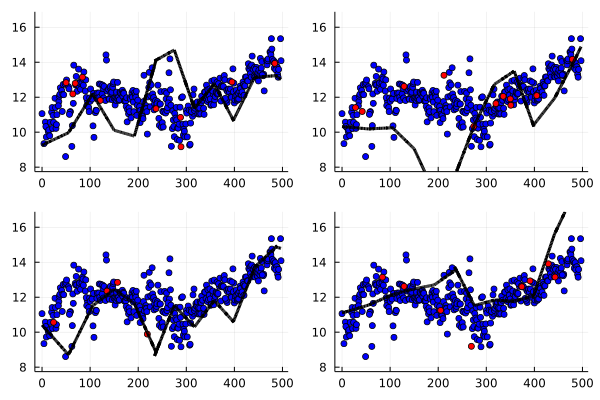

In [13]:

traces    = [first(Gen.importance_resampling(regression_with_outliers, (xs,), observations, 100)) for i in 1:4]
#log_probs = [get_score(t) for t in traces]
#println("Average log probability: $(logmeanexp(log_probs))")
Plots.plot([visualize_trace(t) for t in traces]...)

In [14]:
# Perform a single block resimulation update of a trace.
function block_resimulation_update(tr)
    (xs,) = get_args(tr)
    n = length(xs)
    NumChunks = div(n, SubChunkSize, RoundUp)
    (tr, _) = mh(tr, select(:Buffer_y))
    for j=1:(NumChunks)
        # Block 1: Update the line's parameters
        line_params = select((:noise,j-1), (:slope,j-1),
                    (:noise,j), (:slope,j),
                    (:noise,j+1), (:slope,j+1))
        (tr, _) = mh(tr, line_params)
    end

    (tr, _) = mh(tr, select((:noise,-1),(:noise,1)))
    
    # Blocks 2-N+1: Update the outlier classifications
    for i=1:n
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end
    
    (tr, _) = mh(tr, select(:prob_outlier))
    
    # Return the updated trace
    tr
end;

In [15]:
function block_resimulation_inference(xs, ys)
    observations = make_constraints(ys)
    (tr, W) = generate(regression_with_outliers, (xs,), observations)
    for iter=1:100
        tr = block_resimulation_update(tr)
    end
    tr
end;

In [16]:
function CreateView(Dur::Int64)
    t, = generate(regression_with_outliers, (xs,), observations)
    traceHistroy = Vector{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}(undef,Dur)

    viz_Log = Plots.@animate for i in 1:Dur
        t = block_resimulation_update(t)
        Plots.plot([visualize_trace(t), visualize_trace(t;YscaleFunc = exp)]...)
    end;
    return(gif(viz_Log))
end;

┌ Info: Saved animation to 
│   fn = C:\Users\marli\AppData\Local\Temp\jl_iz9WQnlsQ4.gif
└ @ Plots C:\Users\marli\.julia\packages\Plots\tXtrW\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\marli\\AppData\\Local\\Temp\\jl_iz9WQnlsQ4.gif")
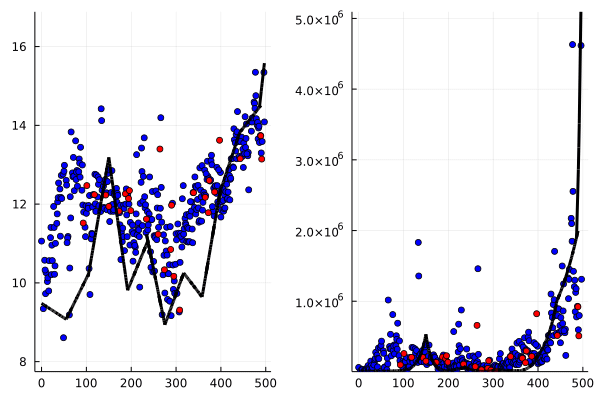

In [18]:
CreateView(100)